In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Read
file_path = 'EDCPCE-replace0toNan.xlsx'
df = pd.read_excel(file_path)

# Preprocess data
df = df.drop(index=47)  # Delete line 48
df.iloc[:, 2].replace('ND', np.nan, inplace=True)
df.iloc[:, 2] = df.iloc[:, 2].astype(float)

df = df.dropna(subset=[df.columns[2]])

X = df.iloc[:,4:].values
y = df.iloc[:, 2].values
print(len(y))

# Use KNNImputer fill in missing X values
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)


37


In [2]:
# Use RFE select top 30 most important X
base_model = RandomForestRegressor(n_estimators=100, random_state=0)
rfe = RFE(base_model, n_features_to_select=30, step=0.05)
X = rfe.fit_transform(X_imputed, y)


In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [4]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=322)


Initial Best Parameters: {'alpha': 0.5689866029018299, 'l1_ratio': 0.05}
R2 score: 0.8991583066605238
MSE: 3.1563040330120353
RMSE: 1.7765990073767448
MAE: 1.5226483891160287


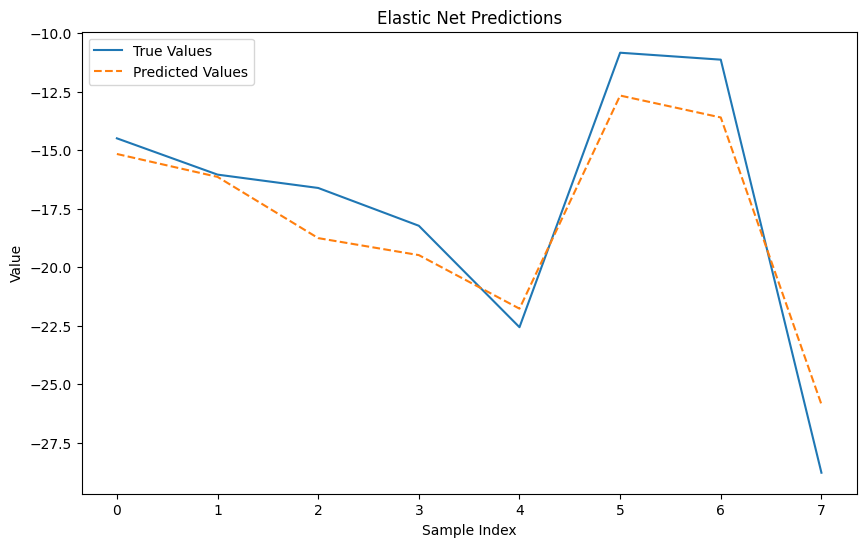

In [5]:
# Define Elastic Net search grid
param_grid = {
    'alpha': np.logspace(-3, 2, 50),
    'l1_ratio': np.linspace(0.05, 0.85, 16)
}

# Use GridSearchCV to adjust Elastic Net hyperparameters
grid_search = GridSearchCV(ElasticNet(max_iter=200000, random_state=0), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Initial best
initial_best_params = grid_search.best_params_
print(f'Initial Best Parameters: {initial_best_params}')
print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Elastic Net Predictions')
plt.legend()
plt.show()

In [6]:
def refined_grid_search(X_train, y_train, X_test, y_test, initial_params, n_iterations):
    best_params = initial_params

    for i in range(n_iterations):
        param_grid = {
            'alpha': np.linspace(best_params['alpha'] / 3, best_params['alpha'] * 3, 7),
            'l1_ratio': np.linspace(max(0, best_params['l1_ratio'] - 0.1), min(1, best_params['l1_ratio'] + 0.1), 6)
        }

        grid_search = GridSearchCV(ElasticNet(max_iter=200000, random_state=0), param_grid, cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_

        model = ElasticNet(max_iter=200000, random_state=0, **best_params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f'Iteration {i + 1} Best Parameters: {best_params}')
        print(f'Iteration {i + 1} R2 score: {r2}')
        print(f'Iteration {i + 1} MSE: {mse}')

        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='True Values')
        plt.plot(y_pred, label='Predicted Values', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Iteration {i + 1} Elastic Net Predictions')
        plt.legend()
        plt.show()

    return best_params, model

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.630e+01, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.524e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 1 Best Parameters: {'alpha': 0.6954280702133476, 'l1_ratio': 0.0}
Iteration 1 R2 score: 0.8798374058657878
Iteration 1 MSE: 3.7610403784694344


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


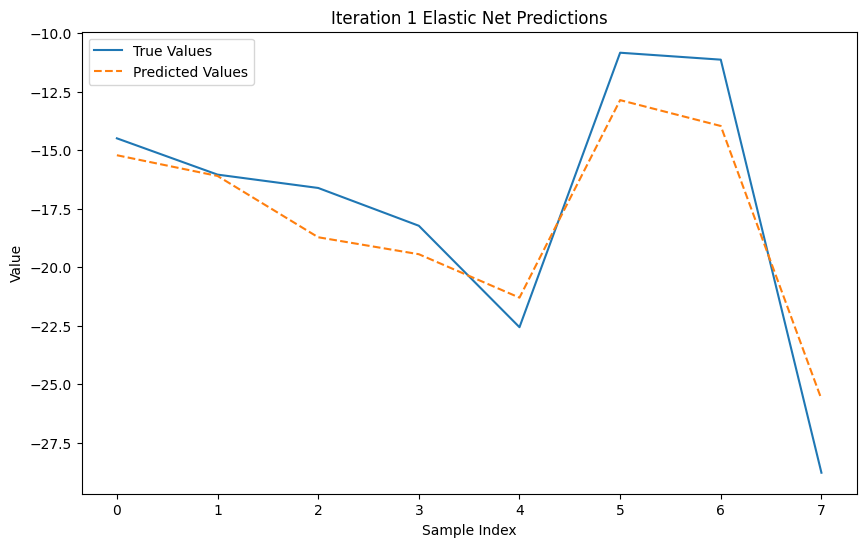

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e+02, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.304e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 2 Best Parameters: {'alpha': 0.5408884990548259, 'l1_ratio': 0.0}
Iteration 2 R2 score: 0.9112996440113679
Iteration 2 MSE: 2.776285106538621


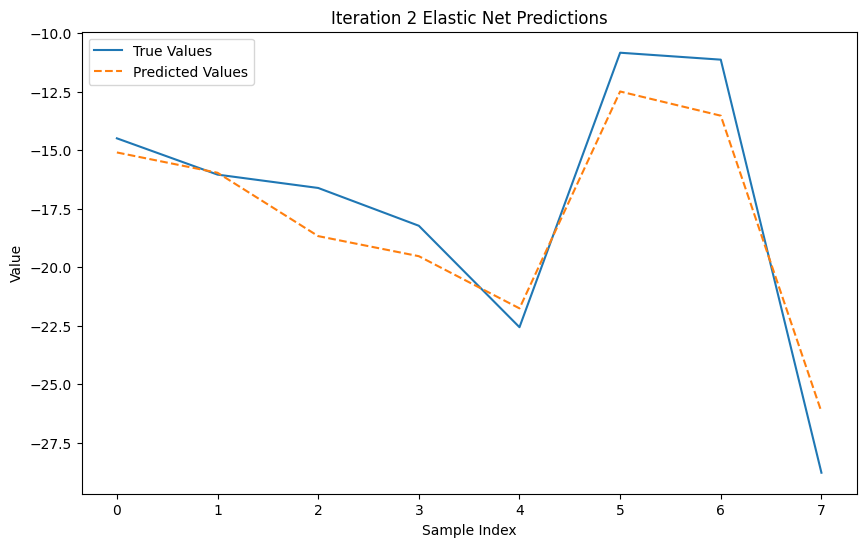

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.417e+01, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.339e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 3 Best Parameters: {'alpha': 0.6610859432892316, 'l1_ratio': 0.0}
Iteration 3 R2 score: 0.8868170566999025
Iteration 3 MSE: 3.542580142953852


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


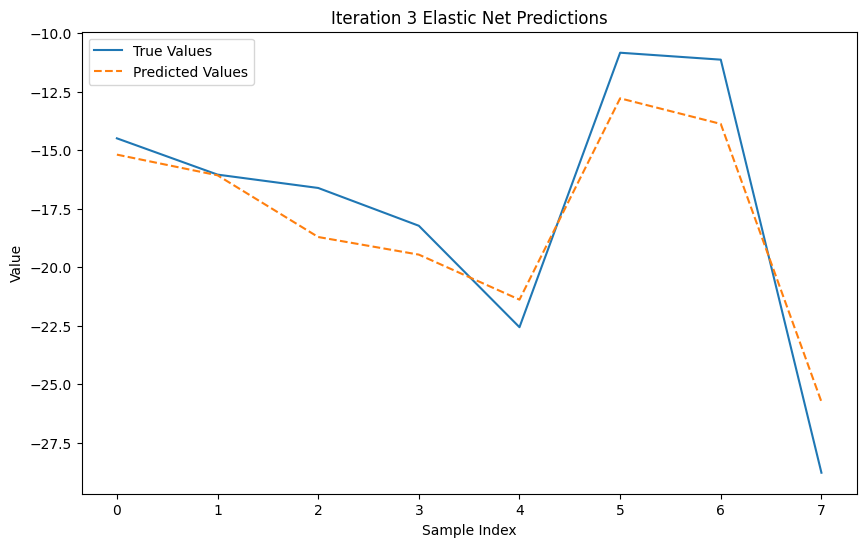

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e+02, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.099e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 4 Best Parameters: {'alpha': 0.5141779558916246, 'l1_ratio': 0.0}
Iteration 4 R2 score: 0.9166600502577078
Iteration 4 MSE: 2.6085065687769764


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


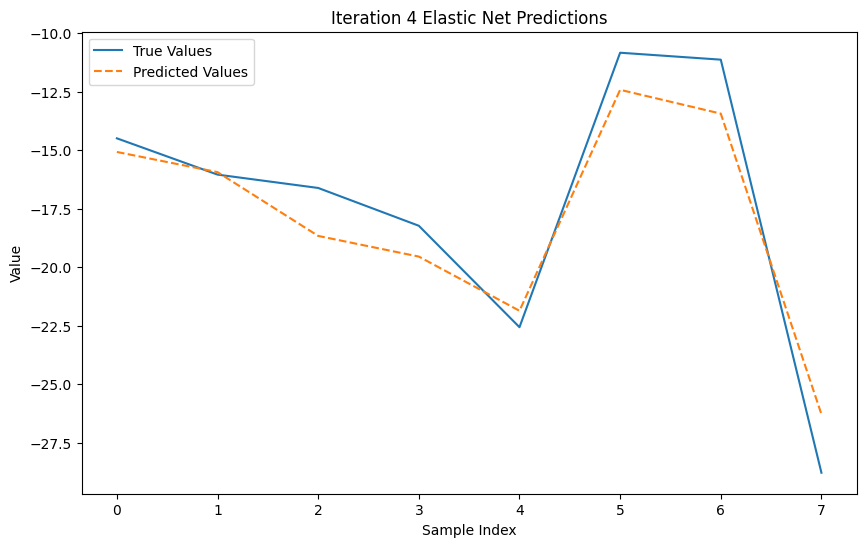

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.208e+01, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.159e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 5 Best Parameters: {'alpha': 0.6284397238675412, 'l1_ratio': 0.0}
Iteration 5 R2 score: 0.8934775802885354
Iteration 5 MSE: 3.3341084605714206


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


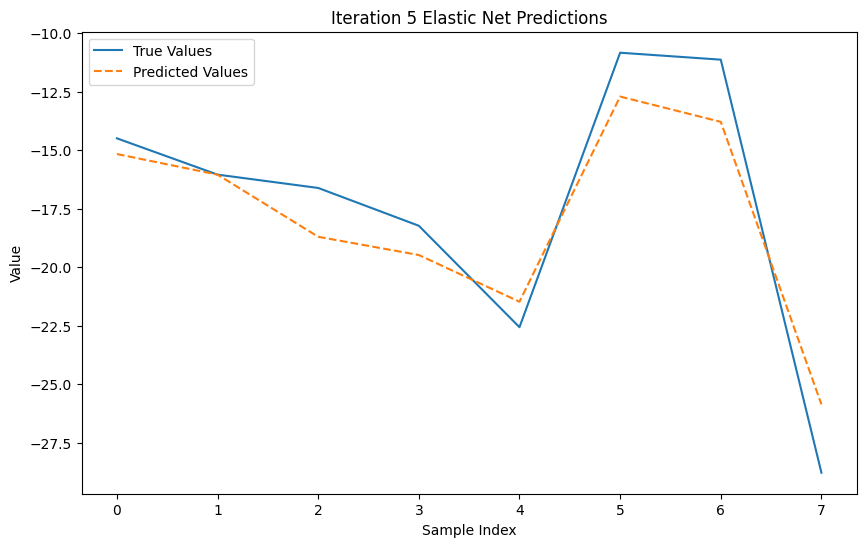

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+02, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.900e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 6 Best Parameters: {'alpha': 0.7680929958381059, 'l1_ratio': 0.0}
Iteration 6 R2 score: 0.8652287153386025
Iteration 6 MSE: 4.21828645696155


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


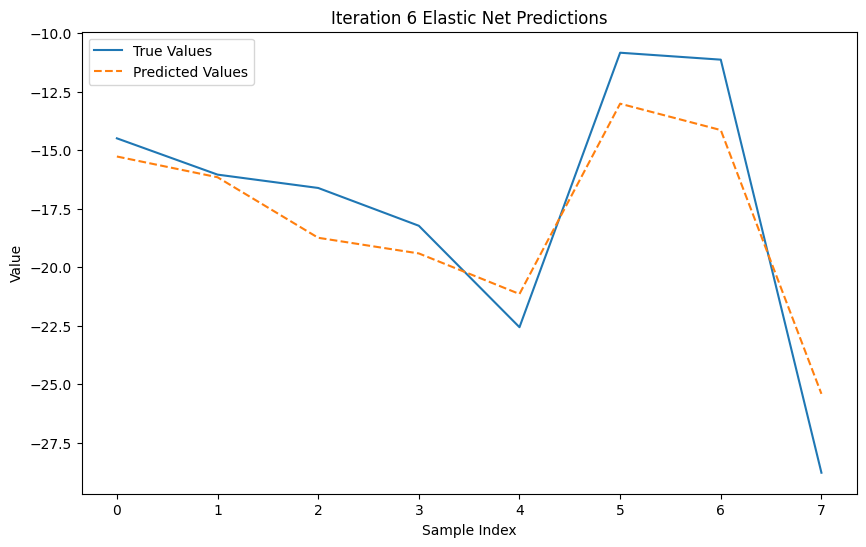

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e+02, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.720e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 7 Best Parameters: {'alpha': 0.5974056634296379, 'l1_ratio': 0.0}
Iteration 7 R2 score: 0.8998151602958169
Iteration 7 MSE: 3.1357447810844135


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


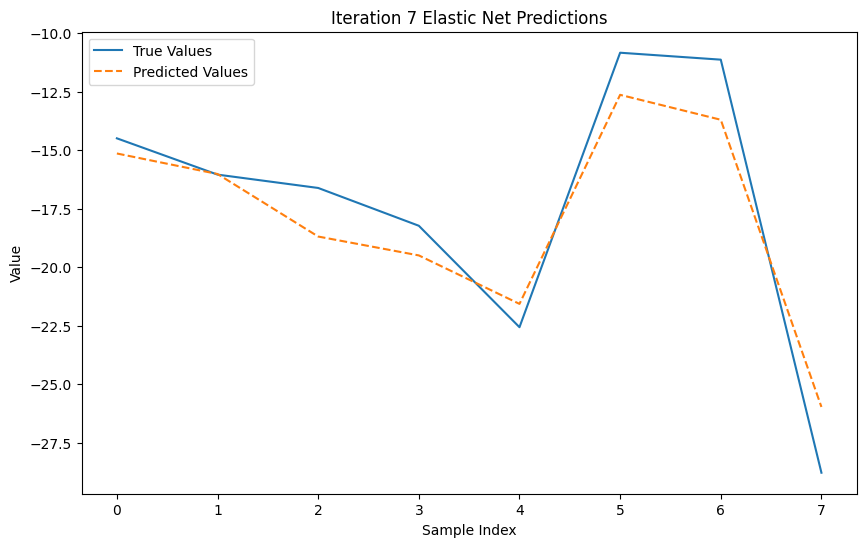

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.838e+01, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.706e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 8 Best Parameters: {'alpha': 0.7301624775251129, 'l1_ratio': 0.0}
Iteration 8 R2 score: 0.8728226140745388
Iteration 8 MSE: 3.9806005116667587


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


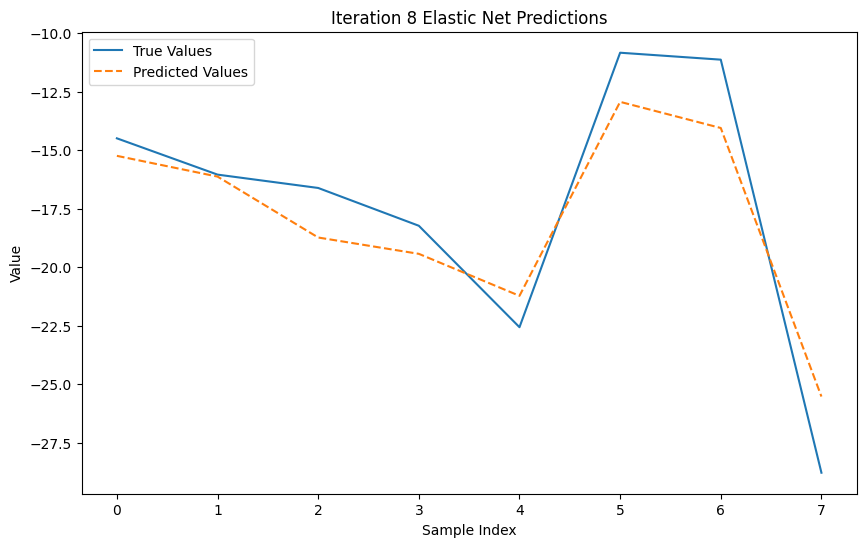

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+02, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.505e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 9 Best Parameters: {'alpha': 0.5679041491861989, 'l1_ratio': 0.0}
Iteration 9 R2 score: 0.9058261896950386
Iteration 9 MSE: 2.9476020029633916


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


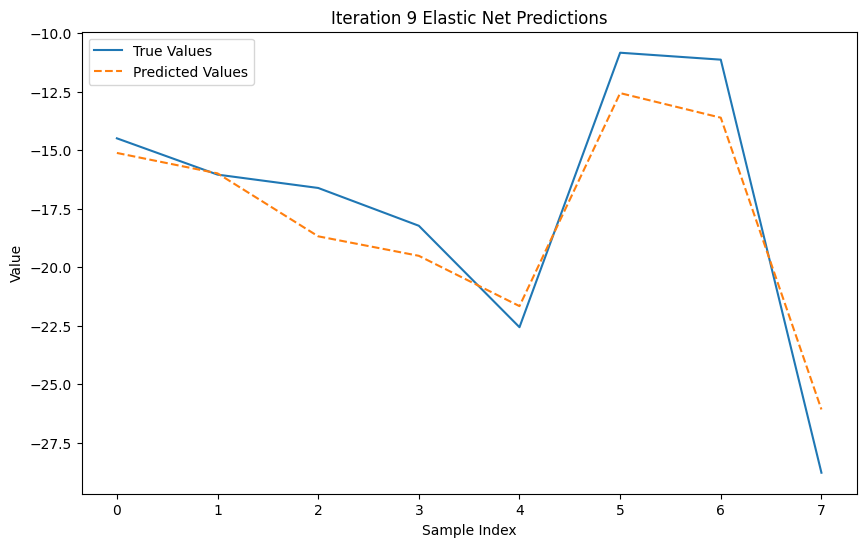

C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.622e+01, tolerance: 8.902e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.517e+01, tolerance: 1.139e-01 Linear regression models with null weight for the l1 regularization term are more efficiently 

Iteration 10 Best Parameters: {'alpha': 0.6941050712275765, 'l1_ratio': 0.0}
Iteration 10 R2 score: 0.880105572003136
Iteration 10 MSE: 3.7526468873171215


C:\Users\99563\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+02, tolerance: 1.317e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


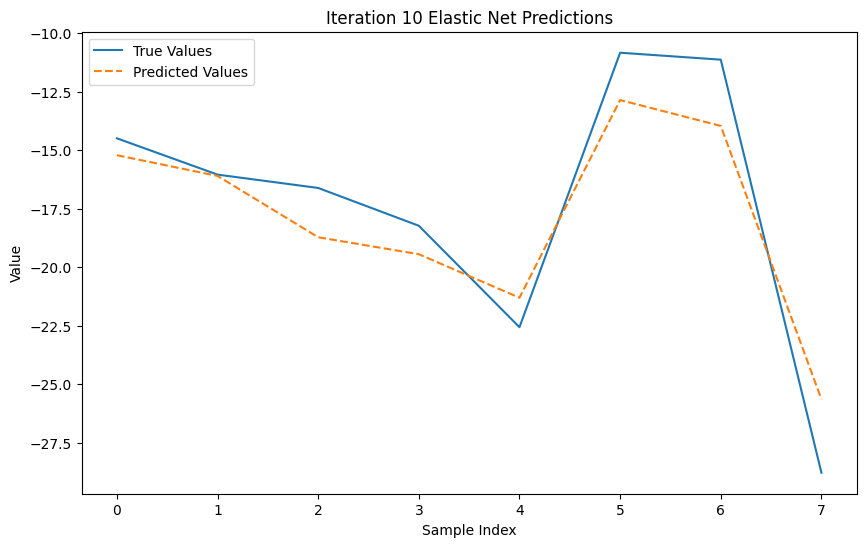

Final Model R2 score: 0.880105572003136
Final Model MSE: 3.7526468873171215
Final Model RMSE: 1.9371749759165076
Final Model MAE: 1.6699396222409837


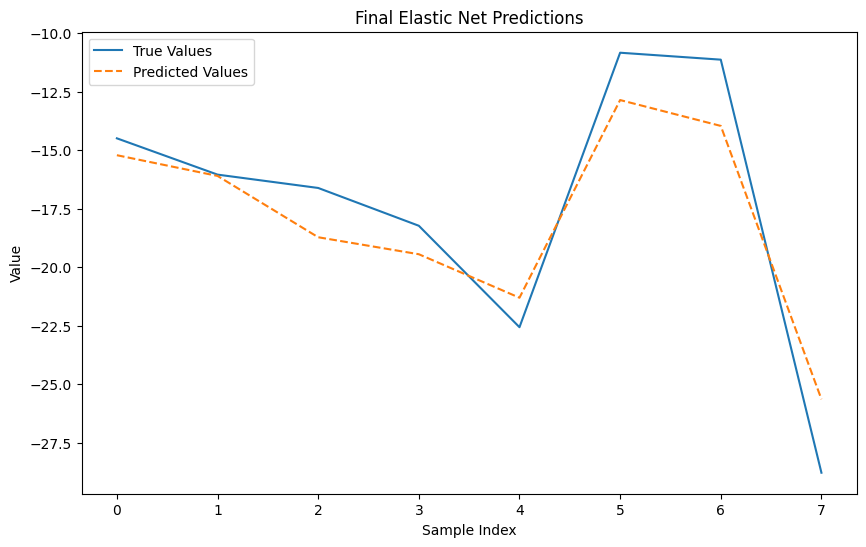

In [7]:

n_iterations = 10 
final_best_params, final_model = refined_grid_search(X_train, y_train, X_test, y_test, initial_best_params, n_iterations)

y_pred_final = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred_final)
final_mse = mean_squared_error(y_test, y_pred_final)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_pred_final)

print(f'Final Model R2 score: {final_r2}')
print(f'Final Model MSE: {final_mse}')
print(f'Final Model RMSE: {final_rmse}')
print(f'Final Model MAE: {final_mae}')
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred_final, label='Predicted Values', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title(f'Final Elastic Net Predictions')
plt.legend()
plt.show()